In [3]:
import cv2
import os
import numpy as np
import random
from tqdm import tqdm
import os
# import monai
from PIL import Image, ImageEnhance
from random import randint
import staintools

def create_directory_if_not_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)

def transparentOverlay(src, overlay, pos=(0,0), scale = 1):
    overlay = cv2.resize(overlay,(0,0),fx=scale,fy=scale)
    h,w,_ = overlay.shape  # Size of foreground
    rows,cols,_ = src.shape  # Size of background Image
    y,x = pos[0],pos[1]    # Position of foreground/overlay image
    
    for i in range(h):
        for j in range(w):
            if x+i >= rows or y+j >= cols:
                continue
            alpha = float(overlay[i][j][3]/255.0) # read the alpha channel 
            src[x+i][y+j] = alpha*overlay[i][j][:3]+(1-alpha)*src[x+i][y+j]
    return src

def focus(image, new_path, filename):
       
    for i in range(1,32,8):
        filename_n = f"{filename}_focus{i}"
        image_blur = cv2.GaussianBlur(image, (i, i), 0)
        image_blur = cv2.cvtColor(image_blur, cv2.COLOR_BGR2RGB)
        cv2.imwrite(f'{new_path}/{filename_n}.jpg', image_blur)

        
def jpeg(image, new_path, filename):
    for c in range (5,76,15):
        filename_n = f"{filename}_jpeg{c}"
        encode_param=[int(cv2.IMWRITE_JPEG_QUALITY), c]
        result, encimg = cv2.imencode('.jpg', image, encode_param)
        decimg = cv2.imdecode(encimg,1)
        decimg = cv2.cvtColor(decimg, cv2.COLOR_BGR2RGB)
        cv2.imwrite(f'{new_path}/{filename_n}.jpg', decimg)

        
def rotator (image, new_path, filename):
    rand_num = random.randint(1,3)
    filename_n = f"{filename}_rotate{rand_num}"
    if rand_num == 1:
        image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    elif rand_num == 2:
        image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    else:
        image = cv2.rotate(image, cv2.ROTATE_180)
    decimg = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cv2.imwrite(f'{new_path}/{filename_n}.jpg', decimg)

def flipper(image, new_path, filename):
    rand_num = random.randint(1,3)
    filename_n = f"{filename}_flip{rand_num}"
    if rand_num == 1:
        image = cv2.flip(image, 0)
    if rand_num == 2:
        image = cv2.flip(image, 1)
    else:
        image = cv2.flip(image, -1)
    decimg = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cv2.imwrite(f'{new_path}/{filename_n}.jpg', decimg)

def elastic(image, new_path, filename):
    for i in range (10,101,30):
        filename_n = f"{filename}_elastic{i}"
        eltra = monai.transforms.Rand2DElastic(
                spacing=(i,i),
                magnitude_range=(1,1),
                prob = 1.0)

        image_el = eltra(image, mode='nearest')
        image_el = np.moveaxis(image_el, 0, -1)
        decimg = cv2.cvtColor(image_el, cv2.COLOR_BGR2RGB)
        cv2.imwrite(f'{new_path}/{filename_n}.jpg', decimg)
        
def brighter(image, new_path, filename):
    for c in range(1,10,3): #4 levels
        c_cor = 1 - (c / 10) # +
        filename_n = f"{filename}_bright{c}"
        pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        image_enh = ImageEnhance.Brightness(pil_image)
        image_out = image_enh.enhance(c_cor)
        image_out = cv2.cvtColor(np.array(image_out), cv2.COLOR_RGB2BGR)
        
        cv2.imwrite(f'{new_path}/{filename_n}.jpg', image_out)


def contraster(image, new_path, filename):
    for c in range(1,10,3):
        c_cor = 1 + (c / 10) 
        filename_n = f"{filename}_contrast{c}"
        pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        image_enh = ImageEnhance.Contrast(pil_image)
        image_out = image_enh.enhance(c_cor)
        image_out = cv2.cvtColor(np.array(image_out), cv2.COLOR_RGB2BGR)
        cv2.imwrite(f'{new_path}/{filename_n}.jpg', image_out)


def thread(image, new_path, filename):
    i = randint (0, 9)
    filename_n = f"{filename}_thread{i}"
    image_over = transparentOverlay(image,threads[i],(0,0),1)    
    image_blur = cv2.GaussianBlur(image_over, (21, 21), 0)
    # (0,0,0) is 3 dimensions of numpy and for every dimension 0 is threshold to be masked
    image_out = np.where(masks[i]==(0, 0, 0), image_over, image_blur)    
    image_out = cv2.cvtColor(image_out, cv2.COLOR_BGR2RGB)
    cv2.imwrite(f'{new_path}/{filename_n}.jpg', image_out)

        
def dark_spot(image, new_path, filename):
    x_coord = [30, 0, -20, -100]
    y_coord = [180, 150, 130, 0]
    for i in range (0,4,1):
        filename_n = f"{filename}_spot{i}"
        he = randint (x_coord[i], y_coord[i])
        wi = randint (x_coord[i], y_coord[i])
        image_out = transparentOverlay(image,sp_lst[i],(he,wi),1)
        image_out = cv2.cvtColor(image_out, cv2.COLOR_BGR2RGB)
        cv2.imwrite(f'{new_path}/{filename_n}.jpg', image_out)

def squamous(image, new_path, filename):
    #randomly select type of squamous epithelial complex
    i = randint(0,19)
    filename_n = f"{filename}_squamous{i}"
    #randomly select coordinates at which it should appear (2x)
    he = randint (0,150)
    wi = randint (0,150)
    image_out = transparentOverlay(image,eps[i],(he,wi),1)
    he = randint (0,150)
    wi = randint (0,150)
    image_out = transparentOverlay(image_out,eps[i],(he,wi),1)
    image_out = cv2.cvtColor(image_out, cv2.COLOR_BGR2RGB)
    cv2.imwrite(f'{new_path}/{filename_n}.jpg', image_out)

def fat(image, new_path, filename):
    filename_n = f"{filename}_fat"
    image_out = transparentOverlay(image,fat_image,(0,0),1)
    image_out = cv2.cvtColor(image_out, cv2.COLOR_BGR2RGB)
    cv2.imwrite(f'{new_path}/{filename_n}.jpg', image_out)
    
def stain(image, new_path, filename):
    i = randint(0,len(stain_types))
    filename_n = f"{filename}_stain{i}"
    stain_type = stain_types[i]
    st = staintools.read_image(stain_dir + stain_type)
#     standardizer = staintools.LuminosityStandardizer()
#     standardizer = staintools.BrightnessStandardizer()
   
    stain_norm = staintools.StainNormalizer(method='macenko')
    stain_norm.fit(st)
    im = np.array(image)
#     im = standardizer.transform(im)
    try:
        im = stain_norm.transform(im)
        image_out = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        cv2.imwrite(f'{new_path}/{filename_n}.jpg', image_out)
    except:
        pass

In [1]:
import copy
import matplotlib.pyplot as plt

In [5]:

#Number of gaussian levels to test
num_g_lev = 16



spot_dir = 'Artifact/10_dark_spots/spots_small/'
thread_dir = 'Artifact/11_synthetic_thread/thread_small/'
epit_dir='Artifact/12_squamous/epit_small/'
#Load spots. Coordinates are for a random range of coordinates where spot can be applied to fully affect the  patch
sp_1 = cv2.imread(spot_dir+'SP1.png', cv2.IMREAD_UNCHANGED) #Coordinates range [30:180, 30:180]
sp_2 = cv2.imread(spot_dir+'SP2.png', cv2.IMREAD_UNCHANGED) #Coordinates range [0:150, 0:150]
sp_3 = cv2.imread(spot_dir+'SP3.png', cv2.IMREAD_UNCHANGED) #Coordinates range [-20:130, -20:130]
sp_4 = cv2.imread(spot_dir+'SP4.png', cv2.IMREAD_UNCHANGED) #Coordinates range [-100:0, -100:0]
sp_lst = [sp_1, sp_2, sp_3, sp_4]

#Load threads
thread1 = cv2.imread(thread_dir+'thread_1.png', cv2.IMREAD_UNCHANGED)
thread2 = cv2.imread(thread_dir+'thread_2.png', cv2.IMREAD_UNCHANGED)
thread3 = cv2.imread(thread_dir+'thread_3.png', cv2.IMREAD_UNCHANGED)
thread4 = cv2.imread(thread_dir+'thread_4.png', cv2.IMREAD_UNCHANGED)
thread5 = cv2.imread(thread_dir+'thread_5.png', cv2.IMREAD_UNCHANGED)
thread6 = cv2.imread(thread_dir+'thread_6.png', cv2.IMREAD_UNCHANGED)
thread7 = cv2.imread(thread_dir+'thread_7.png', cv2.IMREAD_UNCHANGED)
thread8 = cv2.imread(thread_dir+'thread_8.png', cv2.IMREAD_UNCHANGED)
thread9 = cv2.imread(thread_dir+'thread_9.png', cv2.IMREAD_UNCHANGED)
thread10 = cv2.imread(thread_dir+'thread_10.png', cv2.IMREAD_UNCHANGED)

#Load masks
mask1 = np.array(Image.open(thread_dir+'thread_1_mask.jpg'))
mask2 = np.array(Image.open(thread_dir+'thread_2_mask.jpg'))
mask3 = np.array(Image.open(thread_dir+'thread_3_mask.jpg'))
mask4 = np.array(Image.open(thread_dir+'thread_4_mask.jpg'))
mask5 = np.array(Image.open(thread_dir+'thread_5_mask.jpg'))
mask6 = np.array(Image.open(thread_dir+'thread_6_mask.jpg'))
mask7 = np.array(Image.open(thread_dir+'thread_7_mask.jpg'))
mask8 = np.array(Image.open(thread_dir+'thread_8_mask.jpg'))
mask9 = np.array(Image.open(thread_dir+'thread_9_mask.jpg'))
mask10 = np.array(Image.open(thread_dir+'thread_10_mask.jpg'))

masks = [mask1, mask2, mask3, mask4, mask5, mask6, mask7, mask8, mask9, mask10]
threads = [thread1, thread2, thread3, thread4, thread5, thread6, thread7, thread8, thread9, thread10]



#Load squammos
ep_1 = cv2.imread(epit_dir+'sq1.png', cv2.IMREAD_UNCHANGED)
ep_2 = cv2.imread(epit_dir+'sq2.png', cv2.IMREAD_UNCHANGED)
ep_3 = cv2.imread(epit_dir+'sq3.png', cv2.IMREAD_UNCHANGED)
ep_4 = cv2.imread(epit_dir+'sq4.png', cv2.IMREAD_UNCHANGED)
ep_5 = cv2.imread(epit_dir+'sq5.png', cv2.IMREAD_UNCHANGED)
ep_6 = cv2.imread(epit_dir+'sq6.png', cv2.IMREAD_UNCHANGED)
ep_7 = cv2.imread(epit_dir+'sq7.png', cv2.IMREAD_UNCHANGED)
ep_8 = cv2.imread(epit_dir+'sq8.png', cv2.IMREAD_UNCHANGED)
ep_9 = cv2.imread(epit_dir+'sq9.png', cv2.IMREAD_UNCHANGED)
ep_10 = cv2.imread(epit_dir+'sq10.png', cv2.IMREAD_UNCHANGED)
ep_11 = cv2.imread(epit_dir+'sq11.png', cv2.IMREAD_UNCHANGED)
ep_12 = cv2.imread(epit_dir+'sq12.png', cv2.IMREAD_UNCHANGED)
ep_13 = cv2.imread(epit_dir+'sq13.png', cv2.IMREAD_UNCHANGED)
ep_14 = cv2.imread(epit_dir+'sq14.png', cv2.IMREAD_UNCHANGED)
ep_15 = cv2.imread(epit_dir+'sq15.png', cv2.IMREAD_UNCHANGED)
ep_16 = cv2.imread(epit_dir+'sq16.png', cv2.IMREAD_UNCHANGED)
ep_17 = cv2.imread(epit_dir+'sq17.png', cv2.IMREAD_UNCHANGED)
ep_18 = cv2.imread(epit_dir+'sq18.png', cv2.IMREAD_UNCHANGED)
ep_19 = cv2.imread(epit_dir+'sq19.png', cv2.IMREAD_UNCHANGED)
ep_20 = cv2.imread(epit_dir+'sq20.png', cv2.IMREAD_UNCHANGED)

eps = [ep_1, ep_2, ep_3, ep_4, ep_5, ep_6, ep_7, ep_8, ep_9, ep_10, ep_11, ep_12, ep_13, ep_14, ep_15, ep_16, ep_17, ep_18, ep_19, ep_20]


fat_image = cv2.imread('Artifact/13_fat/fat.png', cv2.IMREAD_UNCHANGED)


stain_dir = 'Artifact/15_stain_scheme/schemes_ready/'
stain_types = sorted(os.listdir(stain_dir))

source_dataset= "02_training_native"
source_dir = f'Training_data/{source_dataset}/'
output_dir = 'Corrupted_data/'

dir_names = sorted(os.listdir(source_dir)) # gland, nongland, tumor

artifact_funcs={
    "01_focus":focus,
    "02_jpeg":jpeg,
    "04_rotation":rotator,
     "05_flip":flipper,
#      "07_elastic":elastic,
     "08_bright":brighter,
     "09_contrast":contraster,
     "10_dark_spots":dark_spot,
     "11_synthetic_thread":thread,
     "12_squamous":squamous,
     "13_fat":fat,
     "15_stain_scheme":stain,
    
}

# for artifact,func  in artifact_funcs.items():
#     for dir_name in ['gland','nongland', 'tumor']:
#         work_dir = source_dir +dir_name + "/"    
#         filenames = os.listdir(work_dir)
#         for filename in tqdm(filenames[:1000]):
#             image = cv2.imread(work_dir+filename)
#             image = cv2.resize(image, (300, 300), cv2.INTER_AREA)
#             create_directory_if_not_exists(f"{output_dir}/{source_dataset}/{artifact}/{dir_name}/")
#             func(image, f"{output_dir}/{source_dataset}/{artifact}/{dir_name}/", filename[:-4])
# for artifact,func  in artifact_funcs.items():
# for dir_name in ['gland','nongland', 'tumor']:
#     work_dir = source_dir +dir_name + "/"    
#     filenames = os.listdir(work_dir)
#     for filename in tqdm(filenames[:1000]):
#         image = cv2.imread(work_dir+filename)
#         image = cv2.resize(image, (300, 300), cv2.INTER_AREA)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         create_directory_if_not_exists(f"{output_dir}/{source_dataset}/00_original/{dir_name}/")
#         cv2.imwrite(f"{output_dir}/{source_dataset}/00_original/{dir_name}/{filename}.jpg", image)
# #         func(image, f"{output_dir}/{source_dataset}/{artifact}/{dir_name}/", filename[:-4])


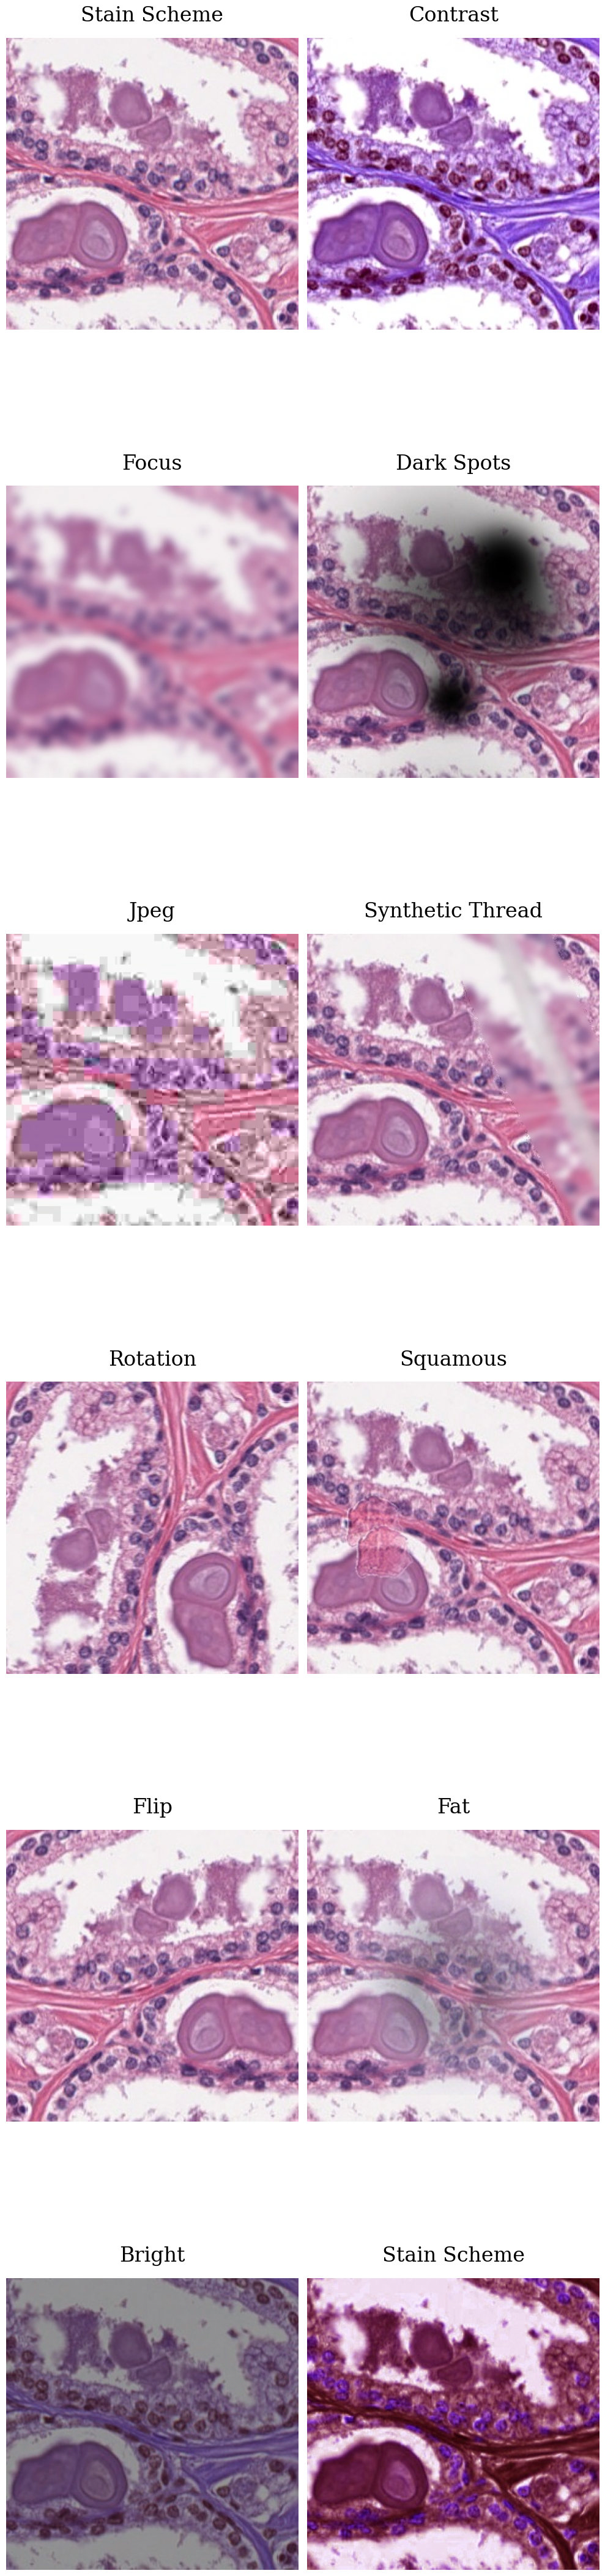

In [21]:
image = cv2.imread('Training_data/01_case_western_native/tumor/tu.901.jpg')
image = cv2.resize(image, (300, 300), cv2.INTER_AREA)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
org_image=image

plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'DejaVu Serif'

fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(10, 45))  # Adjust the figsize according to your needs
# Plot image
axs[0, 0].imshow(org_image)
axs[0, 0].set_title(text.title(),pad=20,fontsize=24)
axs[0, 0].axis('off')  # Turn off axis for images

for idx,(artifact,func)  in enumerate(artifact_funcs.items()):
    dir_name = "tumor"
    work_dir = 'test/' +artifact + "/"    
    filename = os.listdir(work_dir)[-1]
    image = cv2.imread(work_dir+filename)
    img = cv2.resize(image, (300, 300), cv2.INTER_AREA)
    text= artifact[3:].replace("_"," ")
    # Plot image
    axs[(idx+1)%6, (((idx+1)//6))].imshow(img)
    axs[(idx+1)%6, (((idx+1)//6))].set_title(text.title(),pad=20,fontsize=24)
    axs[(idx+1)%6, (((idx+1)//6))].axis('off')  # Turn off axis for images
    
#     print((idx+1)%6,)
    # Plot text
#     axs[(idx+1)%6, (((idx+1)//6))*2].text(0.5, 0.5, text, va='center', ha='left',fontsize=10)
#     axs[(idx+1)%6, (((idx+1)//6))*2].axis('off')  # Turn off axis for texts

plt.tight_layout()
plt.savefig("Corrupted_Data1.png",dpi=300)